# import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore')

# numpy seed값 고정

In [2]:
np.random.seed(42)

# 데이터셋 불러오기

In [3]:
train=pd.read_csv('./data/train_features.csv')
train_labels=pd.read_csv('./data/train_labels.csv')
test=pd.read_csv('./data/test_features.csv')

submission=pd.read_csv('./data/sample_submission.csv')

pd.options.display.max_columns=50

train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


# 3축 센서에 대한 에너지값 변수 추가

In [4]:
def calc_Energy(acc, gy):
    acc_Energy = (acc[0]**2 + acc[1]**2 + acc[2]**2)**(1/3)
    gy_Energy = (gy[0]**2 + gy[1]**2 + gy[2]**2)**(1/3)
    gy_acc_Energy = ((gy[0]-acc[0])**2+(gy[1]-acc[1])**2+(gy[2]-acc[2])**2)**(1/3)
    return acc_Energy, gy_Energy, gy_acc_Energy

In [5]:
temp = calc_Energy([train['acc_x'], train['acc_y'], train['acc_z']], [train['gy_x'], train['gy_y'], train['gy_z']])
train['acc_Energy'] = temp[0]
train['gy_Energy'] = temp[1]
train['gy_acc_Energy'] = temp[2]

temp = calc_Energy([test['acc_x'], test['acc_y'], test['acc_z']], [test['gy_x'], test['gy_y'], test['gy_z']])
test['acc_Energy'] = temp[0]
test['gy_Energy'] = temp[1]
test['gy_acc_Energy'] = temp[2]

train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_Energy,gy_Energy,gy_acc_Energy
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,1.146962,12.465436,12.427938
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,1.200703,12.913284,12.865692
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,1.217403,13.725729,13.692643
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013,1.209981,15.374021,15.314907
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234,1.211254,16.074363,16.017964
...,...,...,...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437,1.009050,25.963234,25.897316
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087,1.002827,25.784692,25.722482
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125,1.006239,25.628060,25.572145
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478,1.001038,25.626266,25.573288


# 가속도의 변화율로 가가속도 변수 추가

In [6]:
dt=0.02
def jerk_signal(signal): 
      return np.array([(signal[i+1]-signal[i])/dt for i in range(len(signal)-1)])
def get_jerk(X):
    X_dt=[]
    for i in tqdm(X['id'].unique()):
        temp=X.loc[X['id']==i]
        for v in X.columns[2:]:
            values=jerk_signal(temp[v].values)
            values=np.insert(values,0,0)
            temp.loc[:,v+'_dt']=values
        X_dt.append(temp)
    return X_dt

In [7]:
train_dt = get_jerk(train)
test_dt = get_jerk(test)

100%|███████████████████████████████████████████████████████████████████████████████| 782/782 [00:04<00:00, 156.81it/s]


# 주파수 성분의 합으로 푸리에 변환 적용

In [8]:
from scipy import fftpack
from numpy.fft import *

def fourier_transform_one_signal(t_signal):
    complex_f_signal= fftpack.fft(t_signal)
    amplitude_f_signal=np.abs(complex_f_signal)
    return amplitude_f_signal

In [9]:
def fourier_transform(X):
    fft=[]
    for i in tqdm(X['id'].unique()):
        temp=X.loc[X['id']==i]
        
        # 가속도 센서와 자이로 센서에 푸리에 변환 적용
        for i in X.columns[2:8]:
            temp[i]=fourier_transform_one_signal(temp[i].values)
        fft.append(temp)
    return pd.concat(fft)

In [10]:
train = pd.concat(train_dt)
train = fourier_transform(train)

test = pd.concat(test_dt)
test = fourier_transform(test)

train

100%|███████████████████████████████████████████████████████████████████████████████| 782/782 [00:01<00:00, 764.73it/s]


,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_Energy,gy_Energy,gy_acc_Energy,acc_x_dt,acc_y_dt,acc_z_dt,gy_x_dt,gy_y_dt,gy_z_dt,acc_Energy_dt,gy_Energy_dt,gy_acc_Energy_dt
0,0,0,558.797337,131.082711,222.252919,1119.161589,2015.703683,709.264425,1.146962,12.465436,12.427938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,1,3.233175,15.689279,12.229014,221.599635,361.903330,477.080942,1.200703,12.913284,12.865692,4.080495,-0.980114,-1.699854,44.735403,-429.504677,337.444793,2.687024,22.392358,21.887693
2,0,2,4.832535,8.199566,3.901211,357.200415,430.568986,452.096143,1.217403,13.725729,13.692643,0.845632,0.192961,-3.546937,-196.018888,-249.173073,-4.620631,0.835012,40.622253,41.347563
3,0,3,5.675383,5.330015,2.527445,340.433376,787.558320,467.307109,1.209981,15.374021,15.314907,-0.575711,-1.762585,1.908626,316.513181,-473.763910,-121.719195,-0.371100,82.414636,81.113199
4,0,4,7.415275,7.980024,6.566908,128.188871,1372.095224,715.824074,1.211254,16.074363,16.017964,0.389598,2.130453,-0.365665,78.686055,-215.435892,-25.361098,0.063656,35.017060,35.152822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874995,3124,595,11.743654,3.796333,12.513870,715.873677,1124.494889,645.627066,1.009050,25.963234,25.897316,1.484646,0.303666,0.800069,-150.644663,-34.630282,-8.380088,-0.679712,8.387109,8.432977
1874996,3124,596,211.498089,82.888508,86.807874,5515.261695,28917.564390,20218.747027,1.002827,25.784692,25.722482,1.474659,-0.005442,1.775771,-39.061611,110.842743,-16.732496,-0.311171,-8.927089,-8.741727
1874997,3124,597,12.175349,6.200258,2.084554,343.695161,464.375112,78.097163,1.006239,25.628060,25.572145,0.915321,-0.407957,1.744566,113.799702,151.036858,-137.001896,0.170620,-7.831611,-7.516832
1874998,3124,598,19.116783,3.830800,6.938661,791.376179,2724.373764,1131.590078,1.001038,25.626266,25.573288,1.709833,-0.796984,0.479107,211.827245,-18.171144,-44.717652,-0.260074,-0.089713,0.057150


# 가가속열의 0값들을 치환하기

In [11]:
copy_col = ['acc_x_dt', 'acc_y_dt', 'acc_z_dt', 'gy_x_dt', 'gy_y_dt', 'gy_z_dt', 'acc_Energy_dt', 'gy_Energy_dt', 'gy_acc_Energy_dt']

# 변화율을 구하는 과정에 0이 된 값들을 다음 값으로 채워놓음
for col in copy_col:
    
    # 600행마다 적용
    for i in range(0, 1875000, 600):
        train[col][i] = train[col][i+1]
        
        # test dataset 크기에 맞게 조건문 적용
        if i < 469200:
            test[col][i] = test[col][i+1]
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_Energy,gy_Energy,gy_acc_Energy,acc_x_dt,acc_y_dt,acc_z_dt,gy_x_dt,gy_y_dt,gy_z_dt,acc_Energy_dt,gy_Energy_dt,gy_acc_Energy_dt
0,0,0,558.797337,131.082711,222.252919,1119.161589,2015.703683,709.264425,1.146962,12.465436,12.427938,4.080495,-0.980114,-1.699854,44.735403,-429.504677,337.444793,2.687024,22.392358,21.887693
1,0,1,3.233175,15.689279,12.229014,221.599635,361.903330,477.080942,1.200703,12.913284,12.865692,4.080495,-0.980114,-1.699854,44.735403,-429.504677,337.444793,2.687024,22.392358,21.887693
2,0,2,4.832535,8.199566,3.901211,357.200415,430.568986,452.096143,1.217403,13.725729,13.692643,0.845632,0.192961,-3.546937,-196.018888,-249.173073,-4.620631,0.835012,40.622253,41.347563
3,0,3,5.675383,5.330015,2.527445,340.433376,787.558320,467.307109,1.209981,15.374021,15.314907,-0.575711,-1.762585,1.908626,316.513181,-473.763910,-121.719195,-0.371100,82.414636,81.113199
4,0,4,7.415275,7.980024,6.566908,128.188871,1372.095224,715.824074,1.211254,16.074363,16.017964,0.389598,2.130453,-0.365665,78.686055,-215.435892,-25.361098,0.063656,35.017060,35.152822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874995,3124,595,11.743654,3.796333,12.513870,715.873677,1124.494889,645.627066,1.009050,25.963234,25.897316,1.484646,0.303666,0.800069,-150.644663,-34.630282,-8.380088,-0.679712,8.387109,8.432977
1874996,3124,596,211.498089,82.888508,86.807874,5515.261695,28917.564390,20218.747027,1.002827,25.784692,25.722482,1.474659,-0.005442,1.775771,-39.061611,110.842743,-16.732496,-0.311171,-8.927089,-8.741727
1874997,3124,597,12.175349,6.200258,2.084554,343.695161,464.375112,78.097163,1.006239,25.628060,25.572145,0.915321,-0.407957,1.744566,113.799702,151.036858,-137.001896,0.170620,-7.831611,-7.516832
1874998,3124,598,19.116783,3.830800,6.938661,791.376179,2724.373764,1131.590078,1.001038,25.626266,25.573288,1.709833,-0.796984,0.479107,211.827245,-18.171144,-44.717652,-0.260074,-0.089713,0.057150


# standard scaler 적용

In [12]:
from sklearn.preprocessing import StandardScaler

def std_scaler(X):
    X_ = X.copy()
    col=X.columns
    scaler = StandardScaler()
    
    X_.iloc[:,2:]= scaler.fit_transform(X_.iloc[:,2:])
    X__ = pd.DataFrame(data = X_,columns =col)
    
    return X__

In [13]:
train_sc = std_scaler(train)
test_sc = std_scaler(test)

In [14]:
train_sc

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_Energy,gy_Energy,gy_acc_Energy,acc_x_dt,acc_y_dt,acc_z_dt,gy_x_dt,gy_y_dt,gy_z_dt,acc_Energy_dt,gy_Energy_dt,gy_acc_Energy_dt
0,0,0,27.356382,8.807207,19.465910,0.376992,0.869226,0.150423,0.495681,-0.272719,-0.276391,0.416474,-0.118648,-0.254818,0.032687,-0.348870,0.376933,0.564398,0.166397,0.162705
1,0,1,-0.054866,0.833464,0.820412,-0.282128,-0.093560,0.011266,0.742974,-0.236152,-0.240632,0.416474,-0.118648,-0.254818,0.032687,-0.348870,0.376933,0.564398,0.166397,0.162705
2,0,2,0.024046,0.315921,0.081086,-0.182551,-0.053585,-0.003708,0.819822,-0.169815,-0.173080,0.086345,0.023792,-0.531253,-0.141476,-0.202252,-0.004836,0.175470,0.300647,0.306038
3,0,3,0.065632,0.117634,-0.040874,-0.194863,0.154242,0.005408,0.785669,-0.035229,-0.040560,-0.058708,-0.213658,0.285230,0.229293,-0.384854,-0.135526,-0.077817,0.608416,0.598934
4,0,4,0.151477,0.300751,0.317742,-0.350724,0.494539,0.154354,0.791528,0.021954,0.016872,0.039805,0.259049,-0.055142,0.057247,-0.174823,-0.027984,0.013483,0.259369,0.260410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874995,3124,595,0.365037,0.011656,0.845701,0.080839,0.350395,0.112282,-0.138940,0.829394,0.823900,0.151559,0.037234,0.119323,-0.108652,-0.027820,-0.009032,-0.142627,0.063259,0.063604
1874996,3124,596,10.220817,5.476964,7.441373,3.605246,16.530576,11.843241,-0.167578,0.814816,0.809618,0.150539,-0.000299,0.265347,-0.027932,0.090456,-0.018354,-0.065232,-0.064247,-0.062897
1874997,3124,597,0.386337,0.177768,-0.080193,-0.192468,-0.033904,-0.227861,-0.151875,0.802027,0.797338,0.093457,-0.049174,0.260677,0.082648,0.123135,-0.152583,0.035945,-0.056180,-0.053875
1874998,3124,598,0.728823,0.014037,0.350745,0.136284,1.281790,0.403540,-0.175811,0.801880,0.797431,0.174540,-0.096411,0.071287,0.153562,-0.014438,-0.049587,-0.054502,0.000834,0.001911


# 사용가능 GPU 확인

In [15]:
import tensorflow as tf
tf.__version__
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10973747590409545639,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9874664320
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3546516921980736979
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"]

# 학습 모델 관련 라이브러리 import

In [16]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from keras.models import Sequential
from keras.layers import Dense, LSTM,Bidirectional,Dropout
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras import backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.model_selection import KFold,StratifiedKFold
from numpy.random import seed
import tensorflow.keras

Using TensorFlow backend.


# train, test dataset, label 설정

In [17]:
X=np.array(train_sc.iloc[:,2:]).reshape(-1, 600, 18)
X.shape

(3125, 600, 18)

In [18]:
test_x=np.array(test_sc.iloc[:,2:]).reshape(-1, 600, 18)
test_x.shape

(782, 600, 18)

In [19]:
y = train_labels['label'].values

# 라벨 one hot encoding
y = tf.keras.utils.to_categorical(train_labels['label']) 
y.shape

(3125, 61)

# 3중 1D-CNN으로 모델 구성
+ 활성화 함수로 convolution 층마다 relu 함수 적용
+ 모든 CNN kernel size 6
+ 모든 convolution 층에 dropout 0.3 적용
+ 출력 활성화 함수 softmax
+ loss function: categorical crossentropy
+ optimizer: Adam

In [20]:
def cnn_model(input_shape, classes):
    seed(2021)
    tf.random.set_seed(2021)

    input_layer = keras.layers.Input(input_shape)
    conv1 = tf.keras.layers.Conv1D(filters=128, kernel_size=6, padding='same')(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)
    conv1 = keras.layers.Dropout(rate=0.3)(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=6, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)
    conv2 = keras.layers.Dropout(rate=0.3)(conv2)

    conv3 = keras.layers.Conv1D(128, kernel_size=6,padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)
    conv3 = keras.layers.Dropout(rate=0.3)(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(classes, activation='softmax')(gap)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='categorical_crossentropy', optimizer = tf.optimizers.Adam(),
                  metrics=['accuracy'])

    return model

# train에서 사용할 rolling 함수(data augmentation)

In [21]:
def rolling(X):
    X_ = X.copy()
    for i in range(X_.shape[0]):
        X_[i] = np.roll(X_[i], np.random.choice(X_.shape[1]), axis= 0)
    return X_

# train model

--------------------Fold_1--------------------
Epoch 1/100
88/88 [==============================] - 5s 35ms/step - loss: 2.9258 - accuracy: 0.4297 - val_loss: 1.9983 - val_accuracy: 0.5431
Epoch 2/100
88/88 [==============================] - 2s 25ms/step - loss: 1.6505 - accuracy: 0.5866 - val_loss: 2.0597 - val_accuracy: 0.5495
Epoch 3/100
88/88 [==============================] - 2s 25ms/step - loss: 1.3040 - accuracy: 0.6594 - val_loss: 1.3704 - val_accuracy: 0.6166
Epoch 4/100
88/88 [==============================] - 2s 25ms/step - loss: 1.0708 - accuracy: 0.7032 - val_loss: 1.1572 - val_accuracy: 0.6933
Epoch 5/100
88/88 [==============================] - 2s 25ms/step - loss: 0.9162 - accuracy: 0.7539 - val_loss: 0.9544 - val_accuracy: 0.7732
Epoch 6/100
88/88 [==============================] - 2s 25ms/step - loss: 0.8179 - accuracy: 0.7774 - val_loss: 0.8984 - val_accuracy: 0.7636
Epoch 7/100
88/88 [==============================] - 2s 25ms/step - loss: 0.7020 - accuracy: 0.7984 -

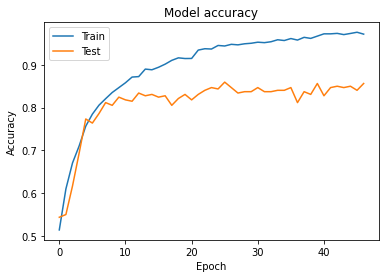

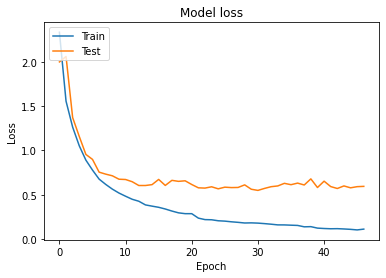

--------------------Fold_2--------------------
Epoch 1/100
88/88 [==============================] - 3s 26ms/step - loss: 2.9485 - accuracy: 0.4245 - val_loss: 1.9018 - val_accuracy: 0.5399
Epoch 2/100
88/88 [==============================] - 2s 25ms/step - loss: 1.6656 - accuracy: 0.5905 - val_loss: 1.6873 - val_accuracy: 0.5655
Epoch 3/100
88/88 [==============================] - 2s 25ms/step - loss: 1.3417 - accuracy: 0.6460 - val_loss: 1.5115 - val_accuracy: 0.5911
Epoch 4/100
88/88 [==============================] - 2s 25ms/step - loss: 1.0637 - accuracy: 0.7091 - val_loss: 1.1998 - val_accuracy: 0.6645
Epoch 5/100
88/88 [==============================] - 2s 25ms/step - loss: 0.9454 - accuracy: 0.7453 - val_loss: 0.9757 - val_accuracy: 0.7540
Epoch 6/100
88/88 [==============================] - 2s 25ms/step - loss: 0.8099 - accuracy: 0.7726 - val_loss: 0.8605 - val_accuracy: 0.7572
Epoch 7/100
88/88 [==============================] - 2s 25ms/step - loss: 0.7112 - accuracy: 0.7957 -

88/88 [==============================] - 2s 25ms/step - loss: 0.0601 - accuracy: 0.9852 - val_loss: 0.5603 - val_accuracy: 0.8435
Epoch 58/100
88/88 [==============================] - 2s 25ms/step - loss: 0.0648 - accuracy: 0.9876 - val_loss: 0.6137 - val_accuracy: 0.8307
Epoch 59/100
88/88 [==============================] - 2s 25ms/step - loss: 0.0599 - accuracy: 0.9868 - val_loss: 0.5649 - val_accuracy: 0.8498

Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 60/100
88/88 [==============================] - 2s 25ms/step - loss: 0.0502 - accuracy: 0.9886 - val_loss: 0.5003 - val_accuracy: 0.8498
Epoch 61/100
88/88 [==============================] - 2s 25ms/step - loss: 0.0444 - accuracy: 0.9910 - val_loss: 0.5275 - val_accuracy: 0.8466
Epoch 62/100
88/88 [==============================] - 2s 25ms/step - loss: 0.0425 - accuracy: 0.9910 - val_loss: 0.5533 - val_accuracy: 0.8371
Epoch 63/100
88/88 [==============================] - 2s 25ms/step - loss:

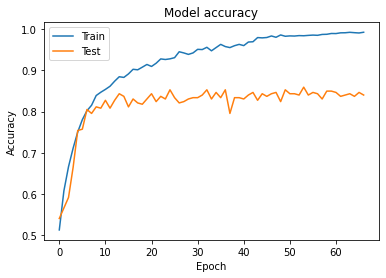

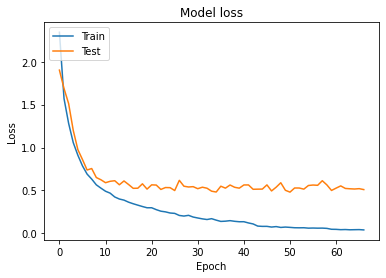

--------------------Fold_3--------------------
Epoch 1/100
88/88 [==============================] - 3s 26ms/step - loss: 2.8950 - accuracy: 0.4365 - val_loss: 1.8910 - val_accuracy: 0.5559
Epoch 2/100
88/88 [==============================] - 2s 25ms/step - loss: 1.6319 - accuracy: 0.5997 - val_loss: 1.8430 - val_accuracy: 0.5623
Epoch 3/100
88/88 [==============================] - 2s 26ms/step - loss: 1.2875 - accuracy: 0.6714 - val_loss: 1.4828 - val_accuracy: 0.6230
Epoch 4/100
88/88 [==============================] - 2s 25ms/step - loss: 1.0874 - accuracy: 0.7122 - val_loss: 1.0775 - val_accuracy: 0.7093
Epoch 5/100
88/88 [==============================] - 2s 27ms/step - loss: 0.9150 - accuracy: 0.7543 - val_loss: 0.9423 - val_accuracy: 0.7252
Epoch 6/100
88/88 [==============================] - 3s 33ms/step - loss: 0.8044 - accuracy: 0.7698 - val_loss: 0.9668 - val_accuracy: 0.7444
Epoch 7/100
88/88 [==============================] - 3s 31ms/step - loss: 0.6886 - accuracy: 0.8063 -

88/88 [==============================] - 3s 29ms/step - loss: 0.0756 - accuracy: 0.9853 - val_loss: 0.4179 - val_accuracy: 0.8690
Epoch 57/100
88/88 [==============================] - 3s 31ms/step - loss: 0.0779 - accuracy: 0.9827 - val_loss: 0.4098 - val_accuracy: 0.8754
Epoch 58/100
88/88 [==============================] - 2s 28ms/step - loss: 0.0721 - accuracy: 0.9840 - val_loss: 0.3995 - val_accuracy: 0.8946
Epoch 59/100
88/88 [==============================] - 3s 31ms/step - loss: 0.0642 - accuracy: 0.9871 - val_loss: 0.4455 - val_accuracy: 0.8722
Epoch 60/100
88/88 [==============================] - 2s 27ms/step - loss: 0.0733 - accuracy: 0.9845 - val_loss: 0.4095 - val_accuracy: 0.8754
Epoch 61/100
88/88 [==============================] - 3s 33ms/step - loss: 0.0734 - accuracy: 0.9846 - val_loss: 0.3997 - val_accuracy: 0.8914

Epoch 00061: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 62/100
88/88 [==============================] - 3s 30ms/step - loss:

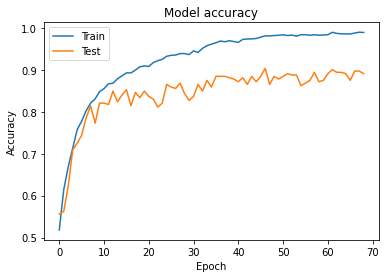

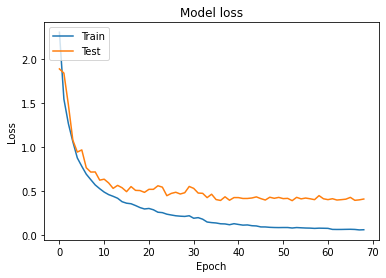

--------------------Fold_4--------------------
Epoch 1/100
88/88 [==============================] - 3s 28ms/step - loss: 2.8831 - accuracy: 0.4262 - val_loss: 2.0910 - val_accuracy: 0.5240
Epoch 2/100
88/88 [==============================] - 2s 26ms/step - loss: 1.5897 - accuracy: 0.6107 - val_loss: 1.9384 - val_accuracy: 0.5335
Epoch 3/100
88/88 [==============================] - 2s 26ms/step - loss: 1.3018 - accuracy: 0.6622 - val_loss: 1.4129 - val_accuracy: 0.6166
Epoch 4/100
88/88 [==============================] - 2s 26ms/step - loss: 1.0906 - accuracy: 0.7069 - val_loss: 1.2749 - val_accuracy: 0.6486
Epoch 5/100
88/88 [==============================] - 2s 28ms/step - loss: 0.9137 - accuracy: 0.7514 - val_loss: 1.0405 - val_accuracy: 0.7188
Epoch 6/100
88/88 [==============================] - 3s 31ms/step - loss: 0.7821 - accuracy: 0.7870 - val_loss: 0.9281 - val_accuracy: 0.7540 - accuracy:  - ETA: 0s - loss: 0.7862 
Epoch 7/100
88/88 [==============================] - 2s 27ms/s

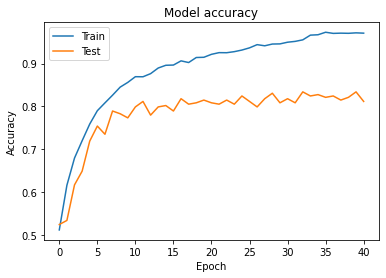

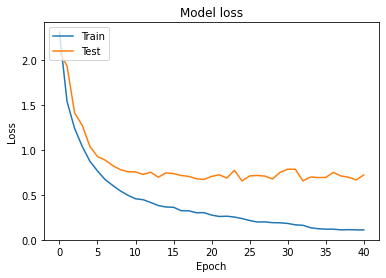

--------------------Fold_5--------------------
Epoch 1/100
88/88 [==============================] - 3s 30ms/step - loss: 2.9155 - accuracy: 0.4537 - val_loss: 1.9393 - val_accuracy: 0.5527
Epoch 2/100
88/88 [==============================] - 3s 29ms/step - loss: 1.6788 - accuracy: 0.5982 - val_loss: 2.1132 - val_accuracy: 0.5463
Epoch 3/100
88/88 [==============================] - 2s 26ms/step - loss: 1.3289 - accuracy: 0.6543 - val_loss: 1.5324 - val_accuracy: 0.6166
Epoch 4/100
88/88 [==============================] - 3s 29ms/step - loss: 1.0857 - accuracy: 0.7155 - val_loss: 1.1371 - val_accuracy: 0.6677
Epoch 5/100
88/88 [==============================] - 2s 26ms/step - loss: 0.9233 - accuracy: 0.7551 - val_loss: 0.9400 - val_accuracy: 0.7284
Epoch 6/100
88/88 [==============================] - 2s 28ms/step - loss: 0.8181 - accuracy: 0.7789 - val_loss: 0.8438 - val_accuracy: 0.7252
Epoch 7/100
88/88 [==============================] - 3s 30ms/step - loss: 0.6863 - accuracy: 0.8084 -

88/88 [==============================] - 3s 30ms/step - loss: 0.0626 - accuracy: 0.9877 - val_loss: 0.4632 - val_accuracy: 0.8626
Epoch 57/100
88/88 [==============================] - 3s 34ms/step - loss: 0.0629 - accuracy: 0.9881 - val_loss: 0.4933 - val_accuracy: 0.8466
Epoch 58/100
88/88 [==============================] - 3s 34ms/step - loss: 0.0713 - accuracy: 0.9845 - val_loss: 0.4334 - val_accuracy: 0.8594
Epoch 59/100
88/88 [==============================] - 3s 33ms/step - loss: 0.0762 - accuracy: 0.9846 - val_loss: 0.4475 - val_accuracy: 0.8626
Epoch 60/100
88/88 [==============================] - 3s 29ms/step - loss: 0.0530 - accuracy: 0.9932 - val_loss: 0.4569 - val_accuracy: 0.8626
Epoch 61/100
88/88 [==============================] - 2s 26ms/step - loss: 0.0574 - accuracy: 0.9875 - val_loss: 0.5095 - val_accuracy: 0.8562

Epoch 00061: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 62/100
88/88 [==============================] - 2s 27ms/step - loss:

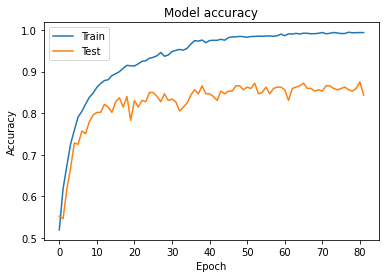

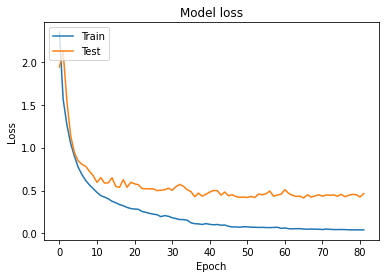

--------------------Fold_6--------------------
Epoch 1/100
88/88 [==============================] - 3s 32ms/step - loss: 2.9434 - accuracy: 0.4457 - val_loss: 2.0028 - val_accuracy: 0.5321
Epoch 2/100
88/88 [==============================] - 2s 27ms/step - loss: 1.6295 - accuracy: 0.5982 - val_loss: 1.9912 - val_accuracy: 0.5449
Epoch 3/100
88/88 [==============================] - 2s 28ms/step - loss: 1.3119 - accuracy: 0.6575 - val_loss: 1.7787 - val_accuracy: 0.5769
Epoch 4/100
88/88 [==============================] - 2s 26ms/step - loss: 1.0872 - accuracy: 0.7075 - val_loss: 1.2215 - val_accuracy: 0.6891
Epoch 5/100
88/88 [==============================] - 2s 26ms/step - loss: 0.9040 - accuracy: 0.7552 - val_loss: 1.0853 - val_accuracy: 0.7276
Epoch 6/100
88/88 [==============================] - 2s 28ms/step - loss: 0.7856 - accuracy: 0.7844 - val_loss: 0.9859 - val_accuracy: 0.7308
Epoch 7/100
88/88 [==============================] - 3s 32ms/step - loss: 0.6976 - accuracy: 0.8025 -

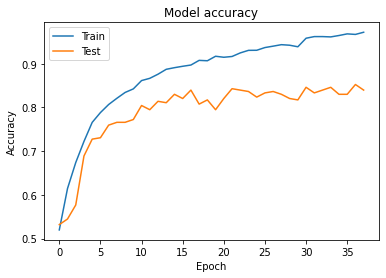

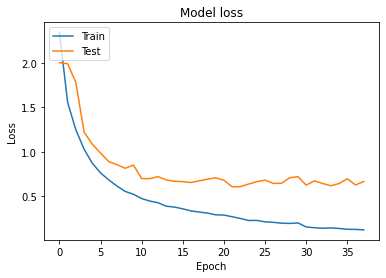

--------------------Fold_7--------------------
Epoch 1/100
88/88 [==============================] - 4s 34ms/step - loss: 2.8842 - accuracy: 0.4534 - val_loss: 1.8553 - val_accuracy: 0.5609
Epoch 2/100
88/88 [==============================] - 3s 32ms/step - loss: 1.6240 - accuracy: 0.6012 - val_loss: 1.6426 - val_accuracy: 0.5769
Epoch 3/100
88/88 [==============================] - 3s 33ms/step - loss: 1.3177 - accuracy: 0.6546 - val_loss: 1.4171 - val_accuracy: 0.6122
Epoch 4/100
88/88 [==============================] - 3s 33ms/step - loss: 1.0675 - accuracy: 0.7175 - val_loss: 1.2010 - val_accuracy: 0.6635
Epoch 5/100
88/88 [==============================] - 3s 32ms/step - loss: 0.9023 - accuracy: 0.7569 - val_loss: 1.0486 - val_accuracy: 0.6955 0s - loss: 0.9054 - ac
Epoch 6/100
88/88 [==============================] - 3s 29ms/step - loss: 0.7893 - accuracy: 0.7815 - val_loss: 0.8180 - val_accuracy: 0.7532
Epoch 7/100
88/88 [==============================] - 2s 28ms/step - loss: 0.69

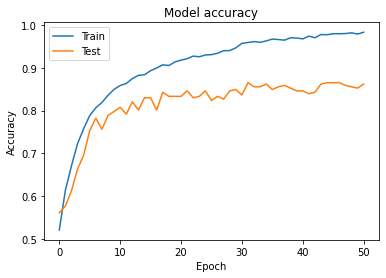

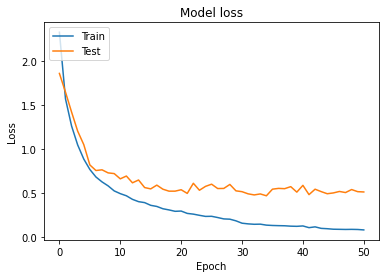

--------------------Fold_8--------------------
Epoch 1/100
88/88 [==============================] - 3s 30ms/step - loss: 2.9156 - accuracy: 0.4448 - val_loss: 1.9001 - val_accuracy: 0.5417
Epoch 2/100
88/88 [==============================] - 3s 30ms/step - loss: 1.6567 - accuracy: 0.6073 - val_loss: 1.6654 - val_accuracy: 0.5769
Epoch 3/100
88/88 [==============================] - 3s 33ms/step - loss: 1.3524 - accuracy: 0.6490 - val_loss: 1.6768 - val_accuracy: 0.6026
Epoch 4/100
88/88 [==============================] - 3s 31ms/step - loss: 1.1154 - accuracy: 0.7091 - val_loss: 1.1989 - val_accuracy: 0.6763
Epoch 5/100
88/88 [==============================] - 3s 31ms/step - loss: 0.9104 - accuracy: 0.7559 - val_loss: 1.0481 - val_accuracy: 0.6827
Epoch 6/100
88/88 [==============================] - 2s 26ms/step - loss: 0.8052 - accuracy: 0.7776 - val_loss: 0.9242 - val_accuracy: 0.7147
Epoch 7/100
88/88 [==============================] - 3s 31ms/step - loss: 0.7165 - accuracy: 0.7900 -

88/88 [==============================] - 3s 29ms/step - loss: 0.0553 - accuracy: 0.9885 - val_loss: 0.4644 - val_accuracy: 0.8974
Epoch 57/100
88/88 [==============================] - 2s 27ms/step - loss: 0.0506 - accuracy: 0.9906 - val_loss: 0.4848 - val_accuracy: 0.8718
Epoch 58/100
88/88 [==============================] - 3s 32ms/step - loss: 0.0535 - accuracy: 0.9898 - val_loss: 0.4575 - val_accuracy: 0.8878
Epoch 59/100
88/88 [==============================] - 2s 25ms/step - loss: 0.0604 - accuracy: 0.9875 - val_loss: 0.4567 - val_accuracy: 0.8910
Epoch 60/100
88/88 [==============================] - 2s 25ms/step - loss: 0.0531 - accuracy: 0.9895 - val_loss: 0.4703 - val_accuracy: 0.8910
Epoch 61/100
88/88 [==============================] - 2s 25ms/step - loss: 0.0441 - accuracy: 0.9942 - val_loss: 0.4660 - val_accuracy: 0.9006
Epoch 62/100
88/88 [==============================] - 2s 25ms/step - loss: 0.0469 - accuracy: 0.9914 - val_loss: 0.4534 - val_accuracy: 0.9038

Epoch 00062

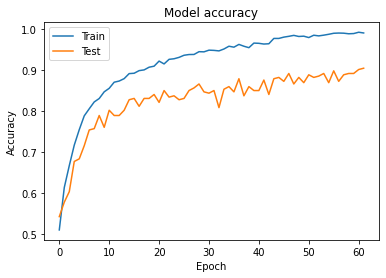

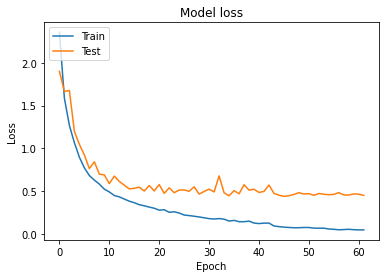

--------------------Fold_9--------------------
Epoch 1/100
88/88 [==============================] - 3s 26ms/step - loss: 2.9404 - accuracy: 0.4376 - val_loss: 1.8854 - val_accuracy: 0.5577
Epoch 2/100
88/88 [==============================] - 2s 25ms/step - loss: 1.6350 - accuracy: 0.6023 - val_loss: 1.7979 - val_accuracy: 0.5641
Epoch 3/100
88/88 [==============================] - 2s 25ms/step - loss: 1.3122 - accuracy: 0.6548 - val_loss: 1.4496 - val_accuracy: 0.6218
Epoch 4/100
88/88 [==============================] - 2s 25ms/step - loss: 1.1009 - accuracy: 0.7166 - val_loss: 1.2336 - val_accuracy: 0.6474
Epoch 5/100
88/88 [==============================] - 2s 25ms/step - loss: 0.9339 - accuracy: 0.7443 - val_loss: 0.9880 - val_accuracy: 0.7276
Epoch 6/100
88/88 [==============================] - 2s 25ms/step - loss: 0.7913 - accuracy: 0.7810 - val_loss: 0.8920 - val_accuracy: 0.7532
Epoch 7/100
88/88 [==============================] - 2s 27ms/step - loss: 0.7221 - accuracy: 0.7876 -

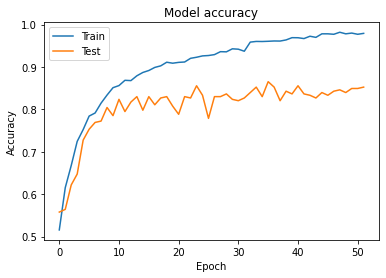

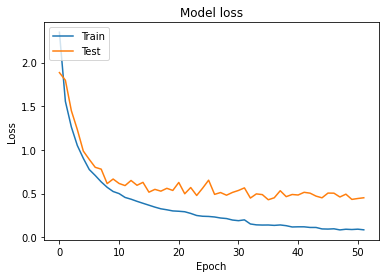

--------------------Fold_10--------------------
Epoch 1/100
88/88 [==============================] - 4s 36ms/step - loss: 2.9113 - accuracy: 0.4377 - val_loss: 1.8842 - val_accuracy: 0.5545
Epoch 2/100
88/88 [==============================] - 3s 31ms/step - loss: 1.6416 - accuracy: 0.6066 - val_loss: 1.8090 - val_accuracy: 0.5385
Epoch 3/100
88/88 [==============================] - 2s 26ms/step - loss: 1.2886 - accuracy: 0.6635 - val_loss: 1.5931 - val_accuracy: 0.6058
Epoch 4/100
88/88 [==============================] - 3s 31ms/step - loss: 1.0807 - accuracy: 0.7090 - val_loss: 1.1334 - val_accuracy: 0.7019
Epoch 5/100
88/88 [==============================] - 3s 34ms/step - loss: 0.8784 - accuracy: 0.7655 - val_loss: 0.8928 - val_accuracy: 0.7660
Epoch 6/100
88/88 [==============================] - 2s 27ms/step - loss: 0.7889 - accuracy: 0.7837 - val_loss: 0.8585 - val_accuracy: 0.7885
Epoch 7/100
88/88 [==============================] - 2s 27ms/step - loss: 0.6959 - accuracy: 0.8008 

88/88 [==============================] - 2s 25ms/step - loss: 0.0854 - accuracy: 0.9835 - val_loss: 0.4267 - val_accuracy: 0.8782

Epoch 00056: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 57/100
88/88 [==============================] - 2s 25ms/step - loss: 0.0895 - accuracy: 0.9815 - val_loss: 0.4146 - val_accuracy: 0.8750
Epoch 58/100
88/88 [==============================] - 2s 25ms/step - loss: 0.0800 - accuracy: 0.9823 - val_loss: 0.4204 - val_accuracy: 0.8782
Epoch 59/100
88/88 [==============================] - 2s 25ms/step - loss: 0.0834 - accuracy: 0.9829 - val_loss: 0.4130 - val_accuracy: 0.8910
Epoch 60/100
88/88 [==============================] - 2s 25ms/step - loss: 0.0772 - accuracy: 0.9840 - val_loss: 0.4204 - val_accuracy: 0.8814
Epoch 61/100
88/88 [==============================] - 2s 25ms/step - loss: 0.0844 - accuracy: 0.9804 - val_loss: 0.4172 - val_accuracy: 0.8782
Epoch 62/100
88/88 [==============================] - 2s 25ms/step - loss: 

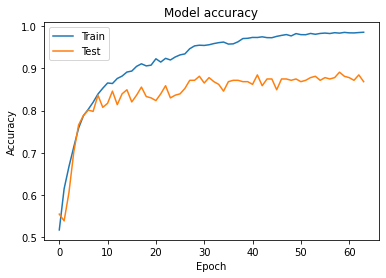

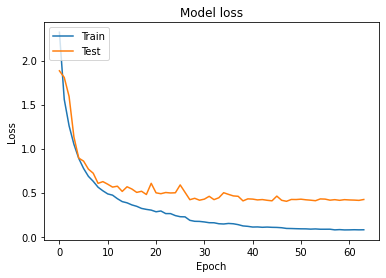


K-fold cross validation Auc: ['0.8466', '0.8435', '0.8882', '0.8243', '0.8722', '0.8429', '0.8622', '0.8718', '0.8654', '0.8750']

K-fold cross validation loss: ['0.5486', '0.4808', '0.3882', '0.6559', '0.4137', '0.6056', '0.4683', '0.4423', '0.4301', '0.4018']


In [22]:
# k-fold 적용, 이때 k = 10
skf = StratifiedKFold(n_splits = 10, random_state = 2021, shuffle = True)

# 콜백 함수로 learning rate tuning, early stopping 적용
reLR = ReduceLROnPlateau(patience = 8,verbose = 1,factor = 0.5) 
es =EarlyStopping(monitor='val_loss', patience=16, mode='min')

# 폴드 별 accuracy, loss, model
accuracy = []
loss=[]
models=[]

# 저장할 파일명
filename = 'kernel666_dr03_patiencex2_furierfix_'

for i, (train, validation) in enumerate(skf.split(X, y.argmax(1))) :
    mc = ModelCheckpoint('./model_kf/'+filename+f'{i + 1}.h5',save_best_only=True, verbose=0, monitor = 'val_loss', mode = 'min', save_weights_only=True)
    print("-" * 20 +"Fold_"+str(i+1)+ "-" * 20)
    
    # 모델의 입력크기 지정
    model = cnn_model((600,18),61)
    
    # data augmentation using rolling
    X_rolled = rolling(X[train])
    X_auged = np.concatenate((X[train], X_rolled), axis=0)
    
    y_auged = np.concatenate((y[train], y[train]), axis=0)
    
    history = model.fit(X_auged, y_auged, epochs = 100, validation_data= (X[validation], y[validation]),
                        verbose=1,batch_size=64,callbacks=[es,mc,reLR])
    model.load_weights('./model_kf/'+filename+f'{i + 1}.h5')

    k_accuracy = '%.4f' % (model.evaluate(X[validation], y[validation])[1])
    k_loss = '%.4f' % (model.evaluate(X[validation], y[validation])[0])

    accuracy.append(k_accuracy)
    loss.append(k_loss)
    models.append(model)
    
    # accuracy, loss graph 출력    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

print('\nK-fold cross validation Auc: {}'.format(accuracy))
print('\nK-fold cross validation loss: {}'.format(loss))

# Train Result

In [23]:
# 평균 accuracy, loss
print('10 folds accuracy average: {}'.format(sum([float(i) for i in accuracy])/10))
print('10 folds loss average: {}'.format(sum([float(i) for i in loss])/10))

10 folds accuracy average: 0.85921
10 folds loss average: 0.48353


In [24]:
test_X=np.array(test_sc.iloc[:,2:]).reshape(782, 600, -1)
test_X.shape

(782, 600, 18)

# Predict

In [25]:
preds = []
for model in models:
    pred = model.predict(test_X)
    preds.append(pred)
pred = np.mean(preds, axis=0)
pred

array([[2.6900109e-06, 2.9240852e-07, 1.2342647e-07, ..., 1.9743838e-03,
        2.8558495e-06, 2.1464016e-06],
       [3.4673332e-04, 7.7718196e-06, 2.2527147e-05, ..., 2.6113380e-06,
        6.4891369e-06, 7.7269742e-06],
       [6.8769988e-04, 1.3730258e-02, 3.5755431e-06, ..., 8.4701162e-05,
        4.8903162e-03, 2.5882630e-03],
       ...,
       [2.0395422e-04, 1.7254994e-06, 3.4880220e-06, ..., 1.1966282e-05,
        8.7568714e-07, 8.1857771e-04],
       [2.7522481e-06, 2.6534550e-04, 7.0589408e-07, ..., 1.6233145e-08,
        7.5852681e-06, 6.8610051e-09],
       [1.7747825e-05, 4.1436610e-07, 2.5465584e-07, ..., 6.7188936e-05,
        1.3466487e-07, 2.2388045e-05]], dtype=float32)

# Create submission file

In [26]:
submission.iloc[:,1:]=pred
submission
submission.to_csv('./predict/'+filename+'.csv',index=False)